In [1]:
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt
import GPy

import pints.emulator as emulator
import pints.emulator.plot as emuplt
import pints.emulator.utils as emutils

## Model creation

In [61]:
# Create a model
model = pints.toy.FitzhughNagumoModel()

# Run a simulation
real_parameters = [0.1, 0.5, 3]

# Why time matters? How Euler/Runge-Kutta, stiff ode method

times = np.linspace(0, 20, 200)
org_values = model.simulate(real_parameters, times)

# take 5-10% of range as your std for noise
Vs, Rs = org_values.reshape(2, 200)
V_std = (Vs.max() - Vs.min()) * .1
R_std = (Rs.max() - Rs.min()) * .1

# Add noise
noise = [V_std, R_std]
values = org_values + np.random.normal(0, noise, org_values.shape)

# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
real_log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise)

In [62]:
bounds = pints.Boundaries(lower = [0, 0, 2], upper = [1, 1, 4])
log_prior = pints.UniformLogPrior(bounds)

In [63]:
input_parameters = log_prior.sample(2000)
likelihoods = np.apply_along_axis(real_log_likelihood, 1, input_parameters)
likelihoods[:5]

array([-1498.70116375,  -747.67336554,  -784.55044092,  -218.3524968 ,
       -2144.05711243])

In [65]:
input_parameters[:5]

array([[0.26478025, 0.74921965, 3.0417854 ],
       [0.17850864, 0.76898116, 2.89623373],
       [0.29734504, 0.07978469, 3.29059012],
       [0.03958946, 0.39125759, 3.15848631],
       [0.66956693, 0.44987529, 2.78825152]])

In [64]:
emu = emulator.GPEmulator(real_log_likelihood, input_parameters, likelihoods, normalize_input = True)

# Plotting surfaces for fixed parameters

In [7]:
# number of splits for each parameter in the surface
n_splits = 50

# fixed values for each of three parameters
parameter_grid = [
    [0.1, 0.5, 1],
    [0.1, 0.5, 1],
    [2, 3, 4]
]

# number of splits for each parameter in the surface
index_to_param = {
    0 : "a",
    1 : "b",
    2 : "c"
}

def plot_fixed_param_grid(log_likelihood, 
                          parameter_grid,
                          index_to_param = None,
                          n_splits = 50,
                          figsize = (10, 10),
                          countour = True,
                          additional_likelihoods = None,
                 ):
    rows, cols = len(parameter_grid), len(parameter_grid[0])
    fig, axes = plt.subplots(rows, cols, figsize = figsize)

    for i, fixed_vals in enumerate(parameter_grid):
        for j, val in enumerate(fixed_vals):
            if countour == False:
                axes[i, j].remove()
                axes[i, j] = fig.add_subplot(rows, cols, i * cols + j + 1, projection = "3d")
            ax = axes[i][j]
            
            if index_to_param:
                ax.set_title("Fixed {} = {}".format(index_to_param[i], val))

            # fix parameter i with value val
            fixed = [(i, val)]
            # generate surfaces
            p1_grid, p2_grid, grid = emutils.generate_grid(bounds.lower(),
                                                    bounds.upper(),
                                                    n_splits,
                                                    fixed = fixed)

            likelihood_prediction = emutils.predict_grid(log_likelihood, grid)

            # plotting
            if countour == True:
                ax.contourf(p1_grid, p2_grid, 
                            likelihood_prediction, 
                            cmap = "Reds")
            else:
                ax.plot_surface(p1_grid, p2_grid, 
                                likelihood_prediction,
                                alpha = 0.8
                               )
                if additional_likelihoods:
                    for likelihood in additional_likelihoods:
                        likelihood_prediction = emutils.predict_grid(likelihood, grid)
                        ax.plot_surface(p1_grid, p2_grid, 
                                        likelihood_prediction,
                                        alpha = 0.5
                                       ) 
            
    return fig, axes

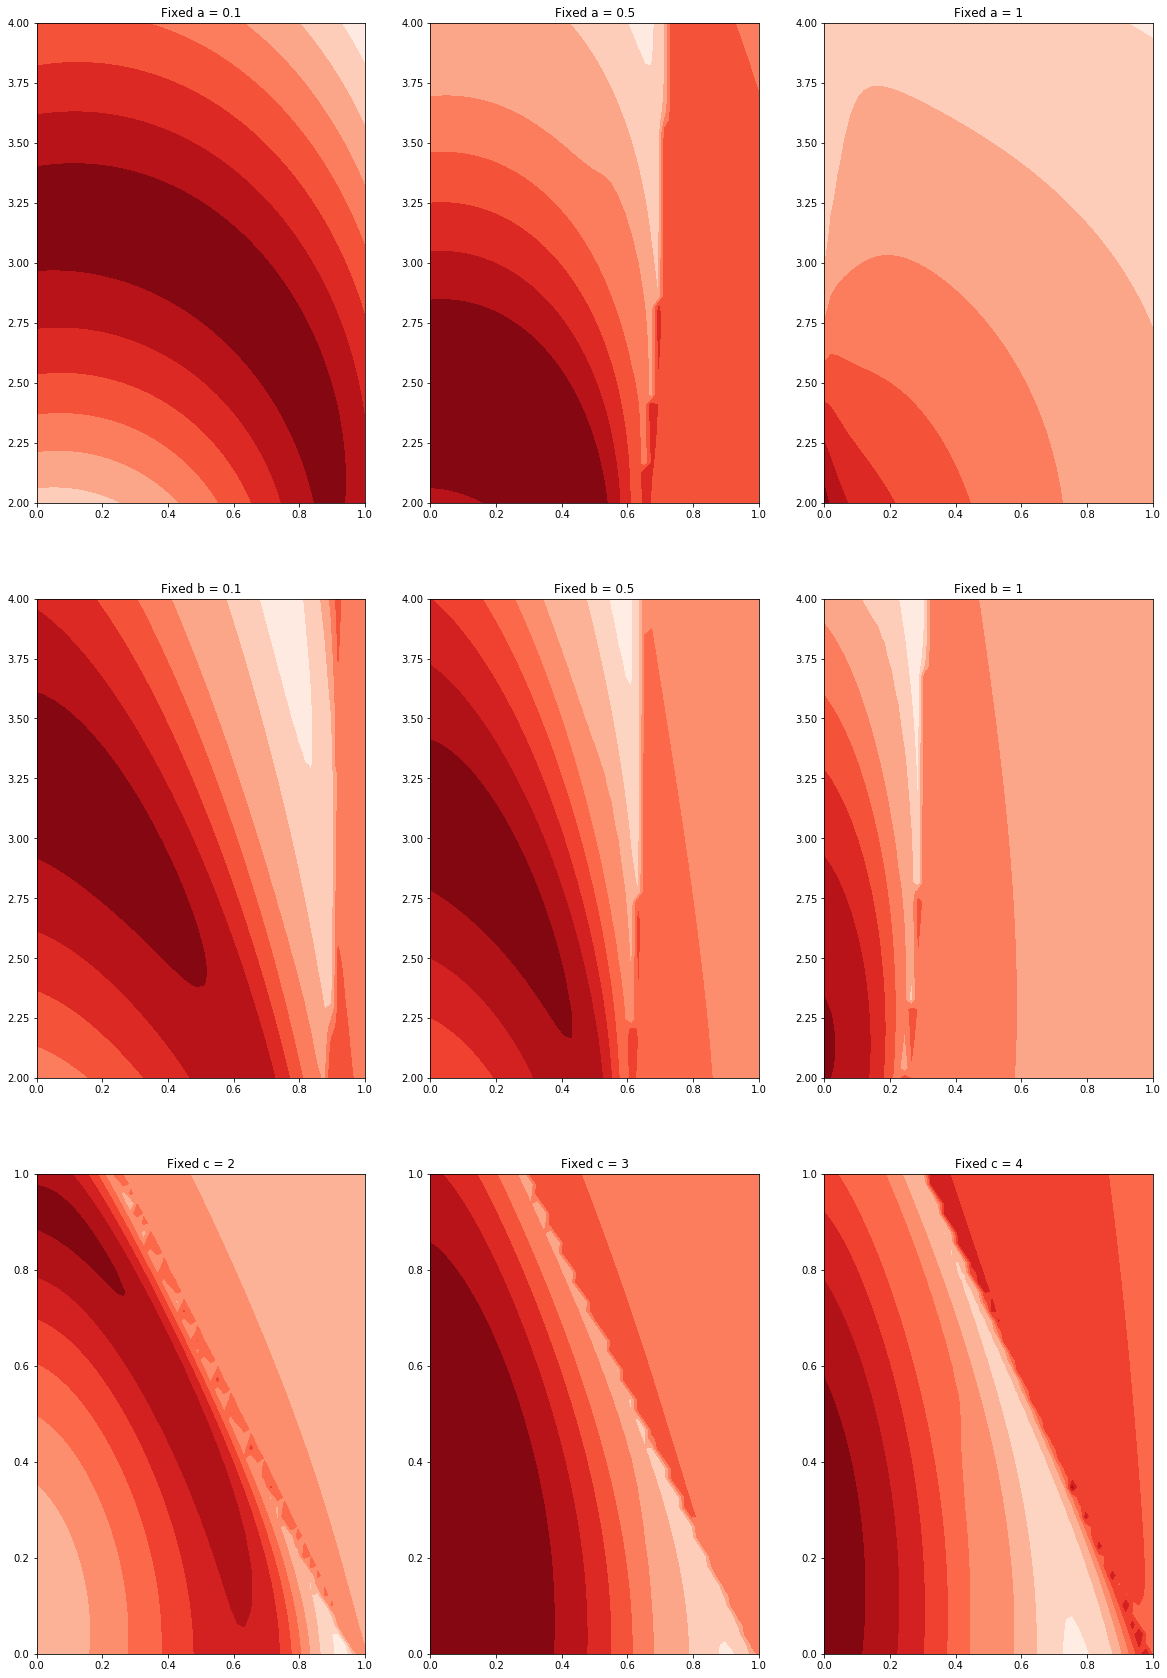

In [8]:
fig, axes = plot_fixed_param_grid(real_log_likelihood, 
                               parameter_grid, 
                               index_to_param=index_to_param,
                               figsize = (20, 30),
                               countour = True
                              )
plt.show(fig)

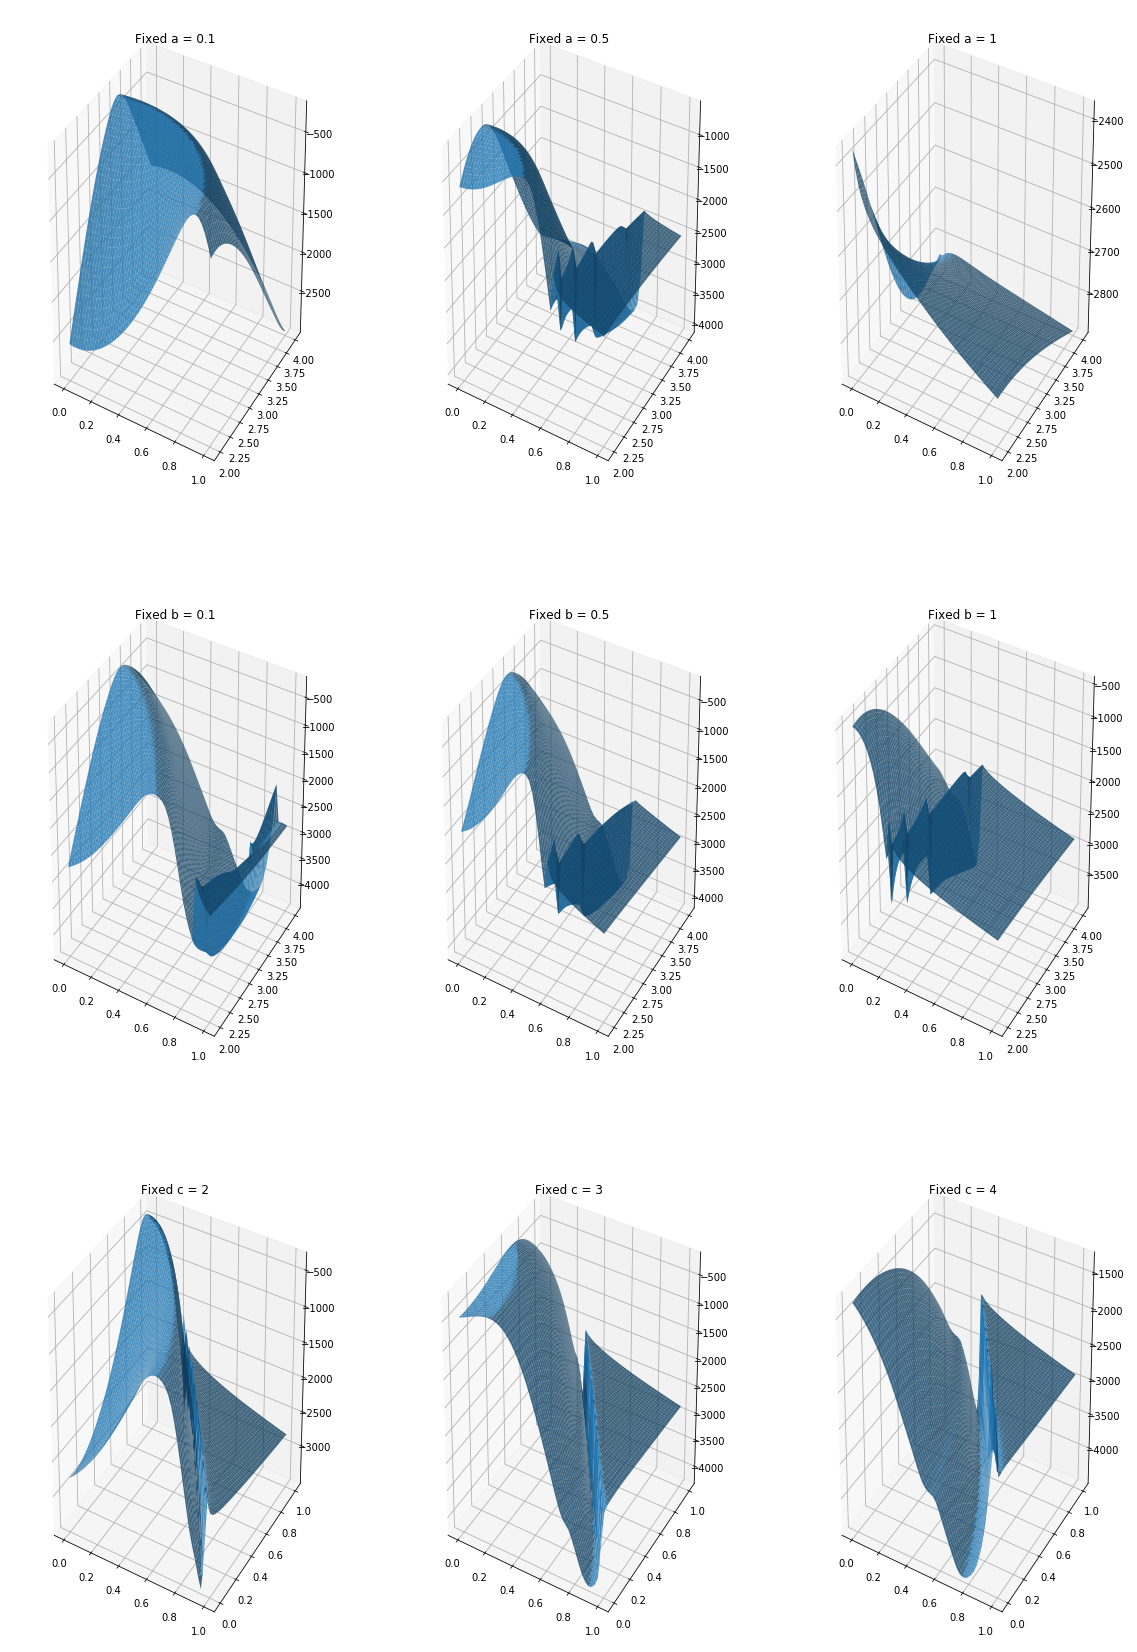

In [9]:
fig, axes = plot_fixed_param_grid(real_log_likelihood, 
                               parameter_grid, 
                               index_to_param=index_to_param,
                               figsize = (20, 30),
                               countour = False
                              )
plt.show(fig)

# Kernel selection

In [59]:
n_parameters = emu.n_parameters()
kernels = [
    GPy.kern.RBF(n_parameters),
    GPy.kern.RatQuad(n_parameters),
    GPy.kern.MLP(n_parameters),
    GPy.kern.Matern52(n_parameters),
    GPy.kern.RatQuad(n_parameters) + GPy.kern.RBF(n_parameters) * GPy.kern.RBF(n_parameters),
    GPy.kern.Matern52(n_parameters) + GPy.kern.RBF(n_parameters) * GPy.kern.RBF(n_parameters),
    GPy.kern.RatQuad(n_parameters) + GPy.kern.RBF(n_parameters) + GPy.kern.RBF(n_parameters),
    GPy.kern.RatQuad(n_parameters) + GPy.kern.RatQuad(n_parameters) + GPy.kern.RatQuad(n_parameters),
    GPy.kern.RBF(n_parameters, lengthscale=2) * (GPy.kern.PeriodicMatern52(1) + GPy.kern.MLP(n_parameters))
]

kern_names = [
    "RBF",
    "RatQuad",
    "MLP",
    "Matern52",
    "RatQuad + RBF*RBF",
    "Matern52 + RBF*RBF",
    "RatQuad + RBF + RBF",
    "RatQuad + RatQuad + RatQuad",
    "PeriodicExp + RatQuad + RBF*RBF",
    "RBF + PeriodicMatern52 + MLP"
]

#optimizer = "scg"
#emu.set_parameters(optimizer = optimizer)

In [60]:
marginal_likelihoods = []

for kern, name in zip(kernels, kern_names):
    emu.set_parameters(kernel = kern)
    emu.fit(optimize = False, normalizer = True)
    emu.optimize(max_iters = 500, messages = False)
    ml = emu.get_log_marginal_likelihood()
    marginal_likelihoods.append(ml)
    print("{}: {:.2f}".format(name, ml))

RBF: 48875.69
KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

In [13]:
best_kern = kernels[np.argmax(marginal_likelihoods)]
print(best_kern)

  mlp.             |               value  |  constraints  |  priors
  variance         |  0.7446016203981994  |      +ve      |        
  weight_variance  |  1593.8002747886524  |      +ve      |        
  bias_variance    |  1489.4208034584058  |      +ve      |        


In [15]:
kernels[5]

In [16]:
# choose kern that in addition to good marginal log likelihood has small variances in parameters
emu.set_parameters(kernel = kernels[5])
emu.fit(normalizer = True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    06s85  0006  -4.172815e+02   9.290911e+02 
    13s45  0012  -4.188077e+02   1.715415e-01 
    17s70  0016  -4.188083e+02   7.627233e-03 
    19s86  0018  -4.188082e+02   1.814660e-01 
    23s26  0021  -4.188083e+02   9.212851e-05 
Runtime:     23s26
Optimization status: Converged



In [17]:
emu.get_gp()

 /Users/maksympetyak/Prog/pints/pints/emulator/_gp_emulator.py:58: UserWarning:Non-negative log_likelihood predicted. Indicative of high uncertainty in predictions.


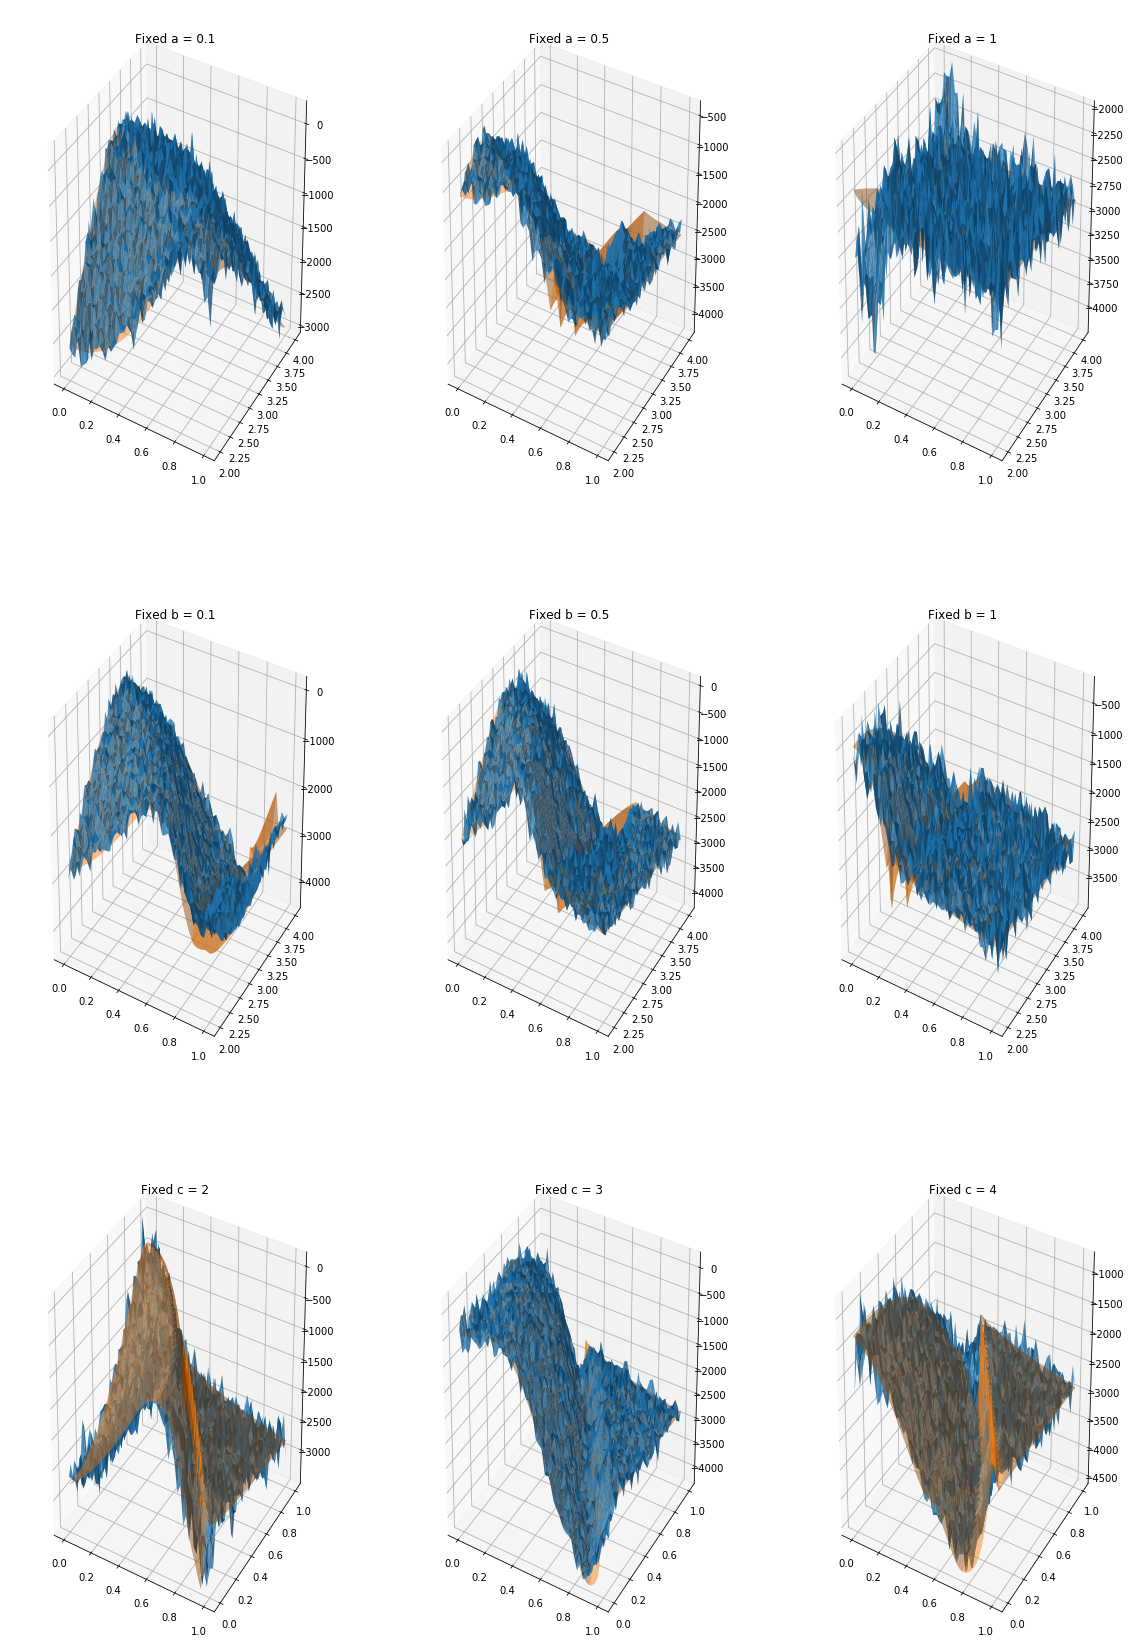

In [18]:
fig, axes = plot_fixed_param_grid(emu, 
                                  parameter_grid, 
                                  index_to_param=index_to_param,
                                  figsize = (20, 30),
                                  countour = False,
                                  additional_likelihoods = [real_log_likelihood]
                              )

 /Users/maksympetyak/Prog/pints/pints/emulator/_gp_emulator.py:58: UserWarning:Non-negative log_likelihood predicted. Indicative of high uncertainty in predictions.


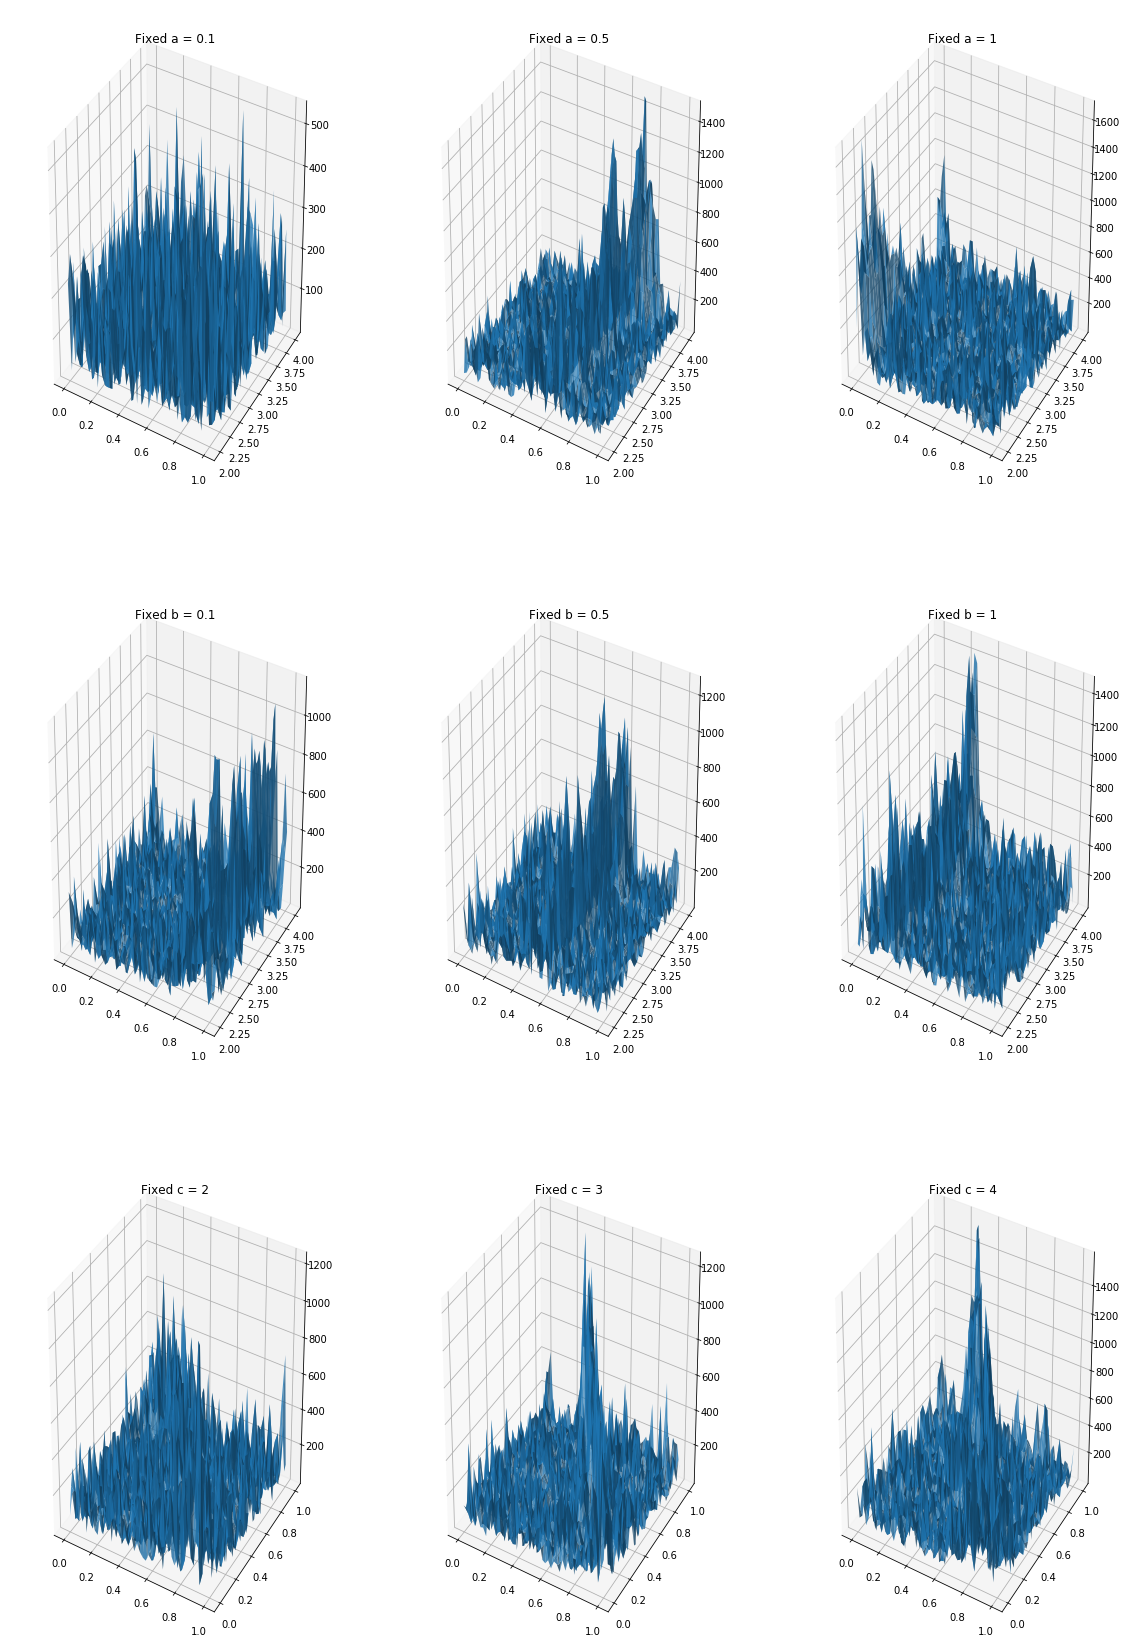

In [19]:
difference_likelihood = lambda x: np.abs(emu(x) - real_log_likelihood(x))
fig, axes = plot_fixed_param_grid(difference_likelihood, 
                                  parameter_grid, 
                                  index_to_param=index_to_param,
                                  figsize = (20, 30),
                                  countour = False,
                                 )

## Timing single prediction

In [20]:
# Model : Time to execute vs number of times (expect to be close to linear?)
# Emulator : Time to execute vs number of training points 
import time

In [21]:
def find_eval_time(func, prior, iters = 10000):
    t_start = time.time()
    for _ in range(iters):
        func(prior.sample(1)[0])
    t_end = time.time()
    return (t_end - t_start) / iters

In [22]:
# Run a simulation
time_splits = [100] + [1000 * i for i in range(1, 21)]
parameters = [0.1, 0.5, 3]
exec_times = []

for time_split in time_splits:
    # Create a log-likelihood function but with more times given
    times = np.linspace(0, 20, time_split)
    org_values = model.simulate(parameters, times)
    values = org_values + np.random.normal(0, noise, org_values.shape)
    problem = pints.MultiOutputProblem(model, times, values)
    log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise)
    
    exec_t = find_eval_time(log_likelihood, log_prior, iters = 5000)
    exec_times.append(exec_t)
    print("Time split {}: {}".format(time_split, exec_t))

Time split 100: 0.002877882623672485
Time split 1000: 0.0029309890270233156
Time split 2000: 0.003103435754776001
Time split 3000: 0.003142237424850464
Time split 4000: 0.003168756437301636
Time split 5000: 0.003239930772781372
Time split 6000: 0.003342736577987671
Time split 7000: 0.0033750159740448
Time split 8000: 0.003416419553756714
Time split 9000: 0.004295879220962524
Time split 10000: 0.0035904075622558594
Time split 11000: 0.0036570181846618654
Time split 12000: 0.0036629850387573243
Time split 13000: 0.003793000364303589
Time split 14000: 0.0037335705280303953
Time split 15000: 0.0036999477386474608
Time split 16000: 0.0036195775985717773
Time split 17000: 0.003801721382141113
Time split 18000: 0.004091970014572143
Time split 19000: 0.004100528049468994
Time split 20000: 0.004234492206573486


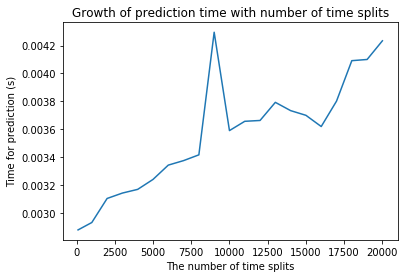

In [23]:
plt.plot(time_splits, exec_times)
plt.title("Growth of prediction time with number of time splits")
plt.xlabel("The number of time splits")
plt.ylabel("Time for prediction (s)")
plt.show()

In [24]:
emu_train_times = []
emu_prediction_times = []

train_sizes = [100 * i for i in range(1, 21)]
print("Kernel used:\n", kern)

for size in train_sizes:
    test_inputs = log_prior.sample(size)
    test_outputs = np.apply_along_axis(real_log_likelihood, 1, test_inputs)
    test_emu = emulator.GPEmulator(real_log_likelihood, test_inputs, test_outputs, normalize_input = True)
    test_emu.set_parameters(kernel = kern)
    
    t_start = time.time()
    test_emu.fit(normalizer = True, messages = False)
    t_end = time.time()
    emu_train_times.append(t_end - t_start)
    
    t_start = time.time()
    find_eval_time(test_emu, log_prior, iters = 10)
    t_end = time.time()
    emu_prediction_times.append(t_end - t_start)
    
    print("Size {}: {:.5f}, {:.5f}".format(size, emu_train_times[-1], emu_prediction_times[-1]))

Kernel used:
   sum.                              |                  value  |  constraints  |  priors
  periodic_exponential.variance     |  8.240973412968244e-07  |      +ve      |        
  periodic_exponential.lengthscale  |     11.137210950454469  |      +ve      |        
  periodic_exponential.period       |     13.972865045096317  |      +ve      |        
  RatQuad.variance                  |    0.29472471244179216  |      +ve      |        
  RatQuad.lengthscale               |    0.19386511828421496  |      +ve      |        
  RatQuad.power                     |     0.1622381842837849  |      +ve      |        
  mul.rbf.variance                  |     0.7627861151145708  |      +ve      |        
  mul.rbf.lengthscale               |     1.5246659547656958  |      +ve      |        
  mul.rbf_1.variance                |     0.7627861151145708  |      +ve      |        
  mul.rbf_1.lengthscale             |     1.5246659547656958  |      +ve      |        
Size 100: 3.77552,

 /anaconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Size 200: 0.56273, 0.01899
Size 300: 0.92173, 0.01446
Size 400: 1.85253, 0.02175
Size 500: 2.63811, 0.01503
Size 600: 3.93202, 0.01714
Size 700: 7.23180, 0.01955
Size 800: 9.30963, 0.02273
Size 900: 14.47161, 0.03093
Size 1000: 13.62411, 0.02386
Size 1100: 22.78067, 0.02836
Size 1200: 23.38126, 0.02916
Size 1300: 16.97800, 0.03234
Size 1400: 18.15802, 0.03610
Size 1500: 25.07765, 0.03189
Size 1600: 24.32186, 0.03615
Size 1700: 24.92783, 0.03770
Size 1800: 57.46852, 0.03888
Size 1900: 31.47098, 0.03936
Size 2000: 67.91386, 0.04438


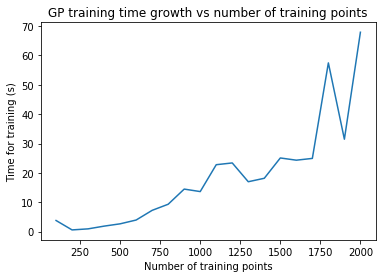

In [25]:
plt.plot(train_sizes, emu_train_times)
plt.title("GP training time growth vs number of training points")
plt.xlabel("Number of training points")
plt.ylabel("Time for training (s)")
plt.show()

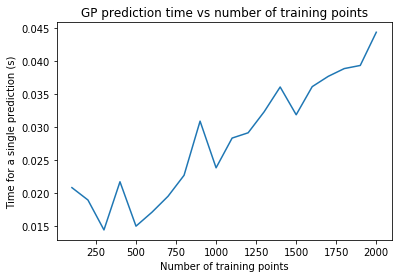

In [26]:
plt.plot(train_sizes, emu_prediction_times)
plt.title("GP prediction time vs number of training points")
plt.xlabel("Number of training points")
plt.ylabel("Time for a single prediction (s)")
plt.show()

## Emulator vs Model

In [35]:
#kern = GPy.kern.RatQuad(n_parameters) + GPy.kern.RBF(n_parameters) * GPy.kern.RBF(n_parameters)
#kern += GPy.kern.White(n_parameters)
train_input = log_prior.sample(4000)
train_target = np.apply_along_axis(real_log_likelihood, 1, train_input)
emu = emulator.GPEmulator(real_log_likelihood, train_input, train_target, normalize_input = True)

In [36]:
emu.set_parameters(kernel = kernels[5])
emu.fit(messages = False, normalizer = True)
emu.get_gp()

In [37]:
emu_posterior = pints.LogPosterior(emu, log_prior)
model_posterior = pints.LogPosterior(real_log_likelihood, log_prior)

In [38]:
xs = [
    np.array(real_parameters) * 0.9,
    np.array(real_parameters) * 1.05,
    np.array(real_parameters) * 1.15,
]

In [39]:
xs

[array([0.09, 0.45, 2.7 ]),
 array([0.105, 0.525, 3.15 ]),
 array([0.115, 0.575, 3.45 ])]

In [40]:
%%time
emu_mcmc = pints.MCMCSampling(emu_posterior, 3, xs, method = pints.PopulationMCMC)
emu_mcmc.set_max_iterations(20000)
emu_mcmc.set_log_to_screen(False)
print('Running...')
emu_chains = emu_mcmc.run()
print('Done!')

Running...


 /Users/maksympetyak/Prog/pints/pints/emulator/_gp_emulator.py:58: UserWarning:Non-negative log_likelihood predicted. Indicative of high uncertainty in predictions.


Done!
CPU times: user 12min 25s, sys: 3.18 s, total: 12min 28s
Wall time: 12min 31s


In [41]:
%%time
# population MCMC
model_mcmc = pints.MCMCSampling(model_posterior, 3, xs, method = pints.PopulationMCMC)
model_mcmc.set_max_iterations(20000)
model_mcmc.set_log_to_screen(False)
# Run!
print('Running...')
model_chains = model_mcmc.run()
print('Done!')

Running...
Done!
CPU times: user 4min 6s, sys: 768 ms, total: 4min 7s
Wall time: 4min 7s


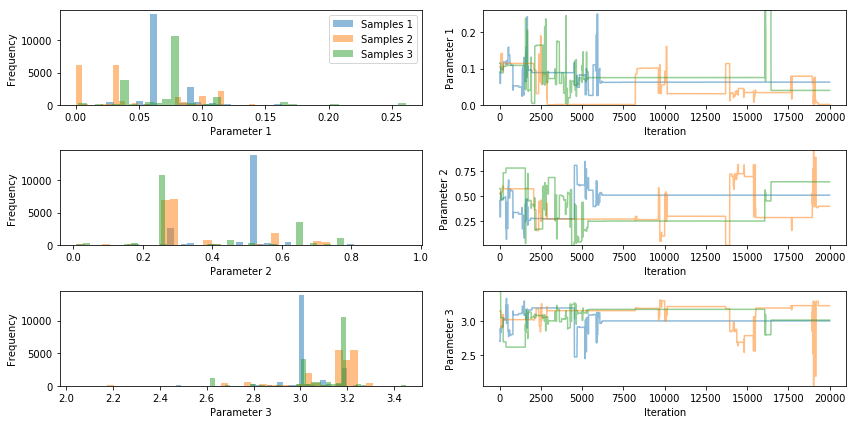

In [42]:
import pints.plot
pints.plot.trace(emu_chains)
plt.show()

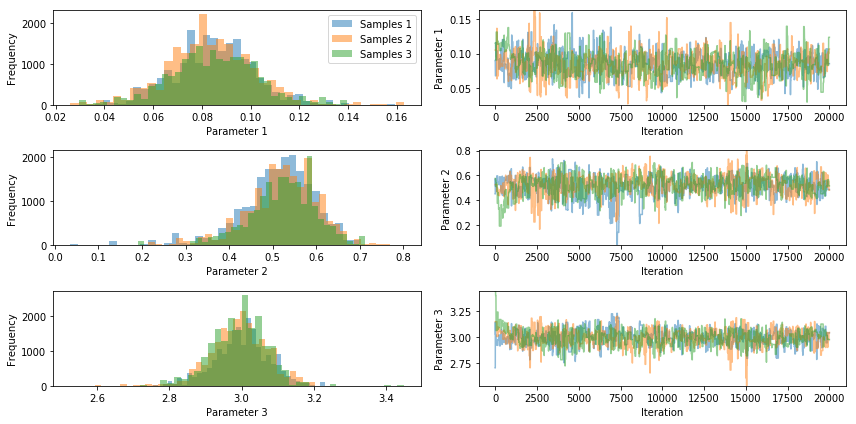

In [43]:
pints.plot.trace(model_chains)
plt.show()

In [44]:
chain = emu_chains[0]
emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
model_prediction = np.apply_along_axis(real_log_likelihood, 1, chain).flatten()

 /Users/maksympetyak/Prog/pints/pints/emulator/_gp_emulator.py:58: UserWarning:Non-negative log_likelihood predicted. Indicative of high uncertainty in predictions.


In [45]:
model_prediction

array([-580.75868257, -580.75868257, -580.75868257, ..., -190.40294563,
       -190.40294563, -190.40294563])

In [46]:
diffs = np.abs(model_prediction - emu_prediction)

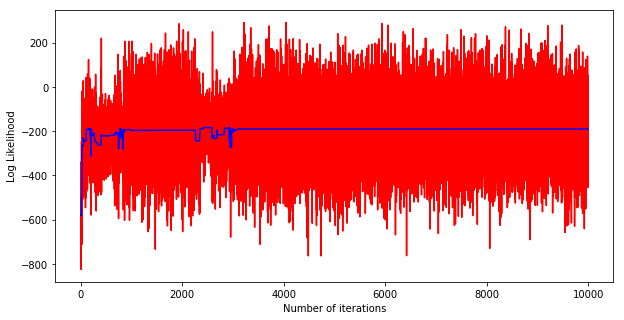

In [47]:
iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Log Likelihood")
plt.plot(iters, emu_prediction, color = "Red")
plt.plot(iters, model_prediction, color = "Blue")
plt.show()

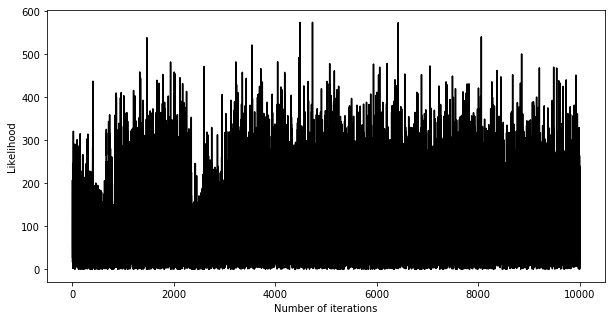

In [48]:
iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

A strong limitation to performance is the size of the training set. If sample uniformly over parameter space the results appear horrible even with high number of training points. Instead, we should sample mostly from high-likelihood areas as they are the ones that are likely to be used by MCMC. 

## post-MCMC emulation

In [49]:
%%time
# population MCMC
model_mcmc = pints.MCMCSampling(model_posterior, 3, xs, method = pints.PopulationMCMC)
model_mcmc.set_max_iterations(2000)
print('Running...')
model_chains = model_mcmc.run()
print('Done!')

Running...
Using Population MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. i     j     Ex. i     j     Ex. i     j     Ex. Time m:s
0     3     0     1     no  0     1     no  0     1     no    0:00.0
1     6     3     0     yes 1     8     yes 3     4     yes   0:00.0
2     9     4     2     no  3     1     yes 6     3     no    0:00.1
3     12    6     4     yes 7     3     no  5     0     no    0:00.1
20    63    5     8     yes 6     9     yes 2     4     no    0:00.4
40    123   5     8     no  3     1     no  8     4     no    0:00.8
60    183   4     2     no  2     3     no  8     1     yes   0:01.1
80    243   1     6     no  2     3     no  7     8     yes   0:01.5
100   303   7     5     no  1     9     no  8     4     yes   0:01.9
120   363   9     7     yes 9     7     yes 5     3     yes   0:02.3
140   423   0     9     yes 7     4     yes 7     6     no    0:02.6
160   483   1     6     no  5     7     yes 1     3     yes   0:03.0
180   543   0     8  

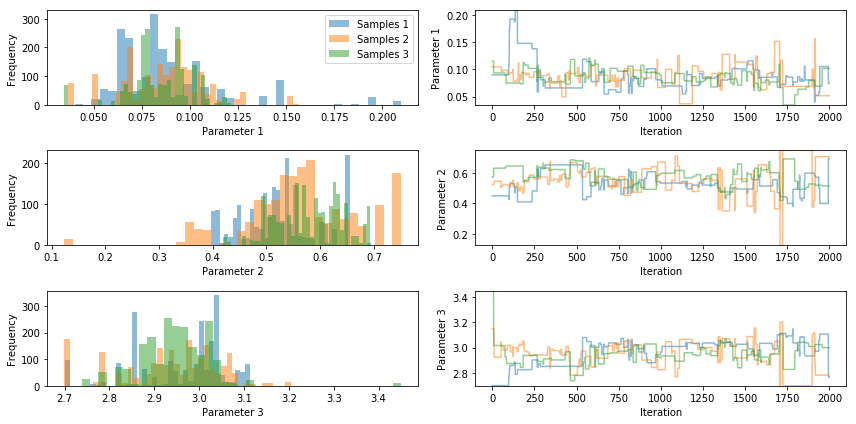

In [50]:
pints.plot.trace(model_chains)
plt.show()

In [51]:
# use small progress in MCMC to derive our train set
train_points = model_chains.reshape((model_chains.size // 3, 3))
train_target = np.apply_along_axis(real_log_likelihood, 1, train_points).flatten()

In [52]:
emu = emulator.GPEmulator(real_log_likelihood, train_points, train_target, normalize_input = True)
emu.set_parameters(kernel = best_kern)
emu.fit(messages = False, normalizer = True)
emu_posterior = pints.LogPosterior(emu, log_prior)

 /anaconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


In [53]:
%%time
emu_mcmc = pints.MCMCSampling(emu_posterior, 3, xs, method = pints.PopulationMCMC)
emu_mcmc.set_max_iterations(10000)
print('Running...')
emu_chains = emu_mcmc.run()
print('Done!')

Running...
Using Population MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. i     j     Ex. i     j     Ex. i     j     Ex. Time m:s
0     3     0     1     no  0     1     no  0     1     no    0:00.1
1     6     2     4     no  2     0     yes 1     0     yes   0:00.2
2     9     2     7     no  9     5     no  0     2     no    0:00.3
3     12    9     4     yes 5     3     yes 2     1     yes   0:00.4
20    63    6     9     no  8     5     no  1     6     no    0:01.8
40    123   2     8     no  8     3     yes 0     8     yes   0:03.6
60    183   5     6     yes 7     8     no  8     7     yes   0:05.5
80    243   4     3     yes 3     6     no  7     0     no    0:07.0
100   303   1     4     yes 7     1     yes 8     3     no    0:08.5
120   363   7     5     yes 6     0     no  3     6     yes   0:10.0
140   423   9     5     no  6     9     yes 6     9     no    0:11.3
160   483   2     1     no  7     3     no  4     7     no    0:12.6
180   543   5     0  

2280  6843  8     3     no  2     5     no  9     1     no    2:41.3
2300  6903  6     3     no  6     4     no  8     1     no    2:42.8
2320  6963  2     9     no  7     9     no  9     7     no    2:44.6
2340  7023  3     9     no  0     1     no  2     1     no    2:46.4
2360  7083  1     5     no  0     2     yes 3     4     no    2:47.9
2380  7143  6     1     no  9     4     no  4     3     no    2:49.2
2400  7203  7     4     yes 7     3     no  7     5     no    2:50.8
2420  7263  7     5     yes 3     0     no  5     9     no    2:53.1
2440  7323  5     7     yes 0     7     yes 1     8     no    2:54.3
2460  7383  4     9     no  9     3     no  5     0     no    2:55.4
2480  7443  0     4     yes 4     5     no  4     2     yes   2:56.6
2500  7503  3     7     yes 8     7     no  8     1     no    2:57.9
2520  7563  9     5     no  8     3     no  8     1     no    2:59.3
2540  7623  9     8     no  7     2     no  5     3     yes   3:00.4
2560  7683  2     7     no  8     

 /Users/maksympetyak/Prog/pints/pints/emulator/_gp_emulator.py:58: UserWarning:Non-negative log_likelihood predicted. Indicative of high uncertainty in predictions.


2840  8523  6     2     no  1     0     no  6     5     no    3:19.9
2860  8583  1     0     no  1     0     no  4     8     no    3:21.1
2880  8643  9     4     no  1     5     no  9     5     no    3:22.5
2900  8703  5     4     yes 4     5     no  6     2     no    3:23.7
2920  8763  9     7     no  5     6     no  5     6     no    3:25.0
2940  8823  9     1     no  8     9     no  3     0     no    3:26.5
2960  8883  5     8     no  9     4     no  4     1     no    3:28.5
2980  8943  7     9     no  6     9     no  1     0     no    3:29.8
3000  9003  4     0     no  8     9     no  5     3     no    3:31.1
3020  9063  3     6     no  1     6     no  2     9     no    3:32.5
3040  9123  2     9     no  5     1     no  5     7     no    3:33.8
3060  9183  3     0     no  8     6     no  5     0     no    3:35.1
3080  9243  3     0     no  8     2     no  4     1     no    3:36.5
3100  9303  7     0     no  9     1     no  9     5     no    3:37.7
3120  9363  5     0     no  8     

5220  15663 9     8     no  4     5     no  8     3     no    6:34.4
5240  15723 5     2     no  0     3     no  3     8     no    6:36.1
5260  15783 7     2     no  8     1     no  1     8     no    6:37.8
5280  15843 3     5     no  4     2     no  3     4     yes   6:39.5
5300  15903 7     8     no  8     1     no  4     1     no    6:41.3
5320  15963 5     2     yes 5     8     no  1     2     no    6:43.3
5340  16023 0     2     no  0     9     no  8     4     no    6:45.0
5360  16083 2     5     no  2     3     no  0     9     no    6:46.7
5380  16143 0     7     no  3     2     no  6     9     no    6:48.6
5400  16203 4     9     no  0     7     no  9     4     yes   6:50.3
5420  16263 6     9     no  6     9     yes 7     9     yes   6:52.1
5440  16323 2     4     no  0     4     no  5     0     no    6:54.1
5460  16383 8     9     no  9     6     no  6     9     no    6:56.1
5480  16443 3     8     yes 4     5     no  7     9     yes   6:58.2
5500  16503 1     0     no  4     

7600  22803 4     2     no  3     0     no  4     3     yes   9:56.4
7620  22863 3     9     no  2     0     yes 4     2     no    9:58.0
7640  22923 1     6     no  5     0     yes 0     8     no    9:59.7
7660  22983 0     2     yes 8     7     yes 8     2     no   10:01.3
7680  23043 5     0     no  9     4     no  8     3     yes  10:02.9
7700  23103 6     8     yes 0     1     no  8     1     yes  10:04.5
7720  23163 5     6     yes 3     6     no  6     4     yes  10:06.2
7740  23223 3     6     no  8     9     no  6     2     no   10:07.7
7760  23283 5     1     no  9     1     no  1     2     no   10:09.4
7780  23343 1     6     no  5     1     no  9     7     no   10:10.9
7800  23403 0     6     no  1     8     no  6     5     no   10:12.7
7820  23463 2     5     no  2     7     no  6     0     no   10:14.2
7840  23523 5     7     no  5     9     no  0     2     no   10:15.6
7860  23583 8     1     no  0     9     no  4     0     no   10:17.1
7880  23643 7     1     no  2     

9980  29943 6     5     no  1     9     no  3     6     yes  13:08.8
10000 30000 8     9     yes 7     9     no  6     1     yes  13:10.4
Halting: Maximum number of iterations (10000) reached.
Done!
CPU times: user 43min 29s, sys: 1min 32s, total: 45min 1s
Wall time: 57min 18s


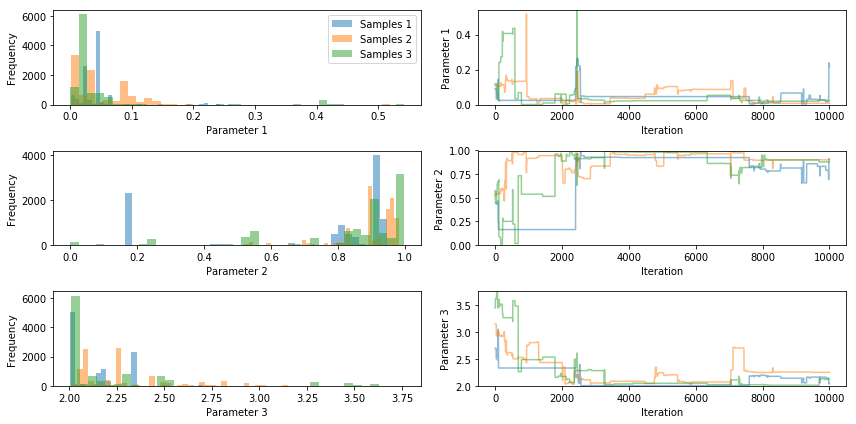

In [54]:
pints.plot.trace(emu_chains)
plt.show()

In [55]:
chain = emu_chains[0]
emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
model_prediction = np.apply_along_axis(real_log_likelihood, 1, chain).flatten()
diffs = np.abs(model_prediction - emu_prediction)

 /Users/maksympetyak/Prog/pints/pints/emulator/_gp_emulator.py:58: UserWarning:Non-negative log_likelihood predicted. Indicative of high uncertainty in predictions.


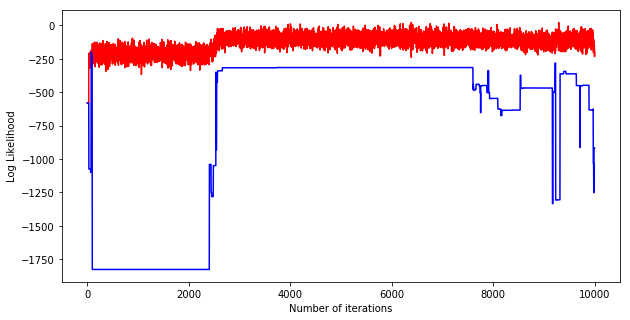

In [56]:
iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Log Likelihood")
plt.plot(iters, emu_prediction, color = "Red")
plt.plot(iters, model_prediction, color = "Blue")
plt.show()

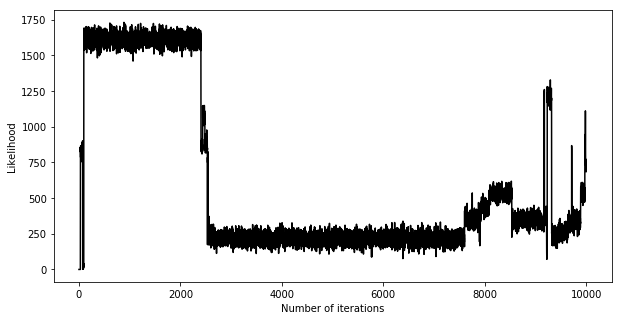

In [57]:
iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

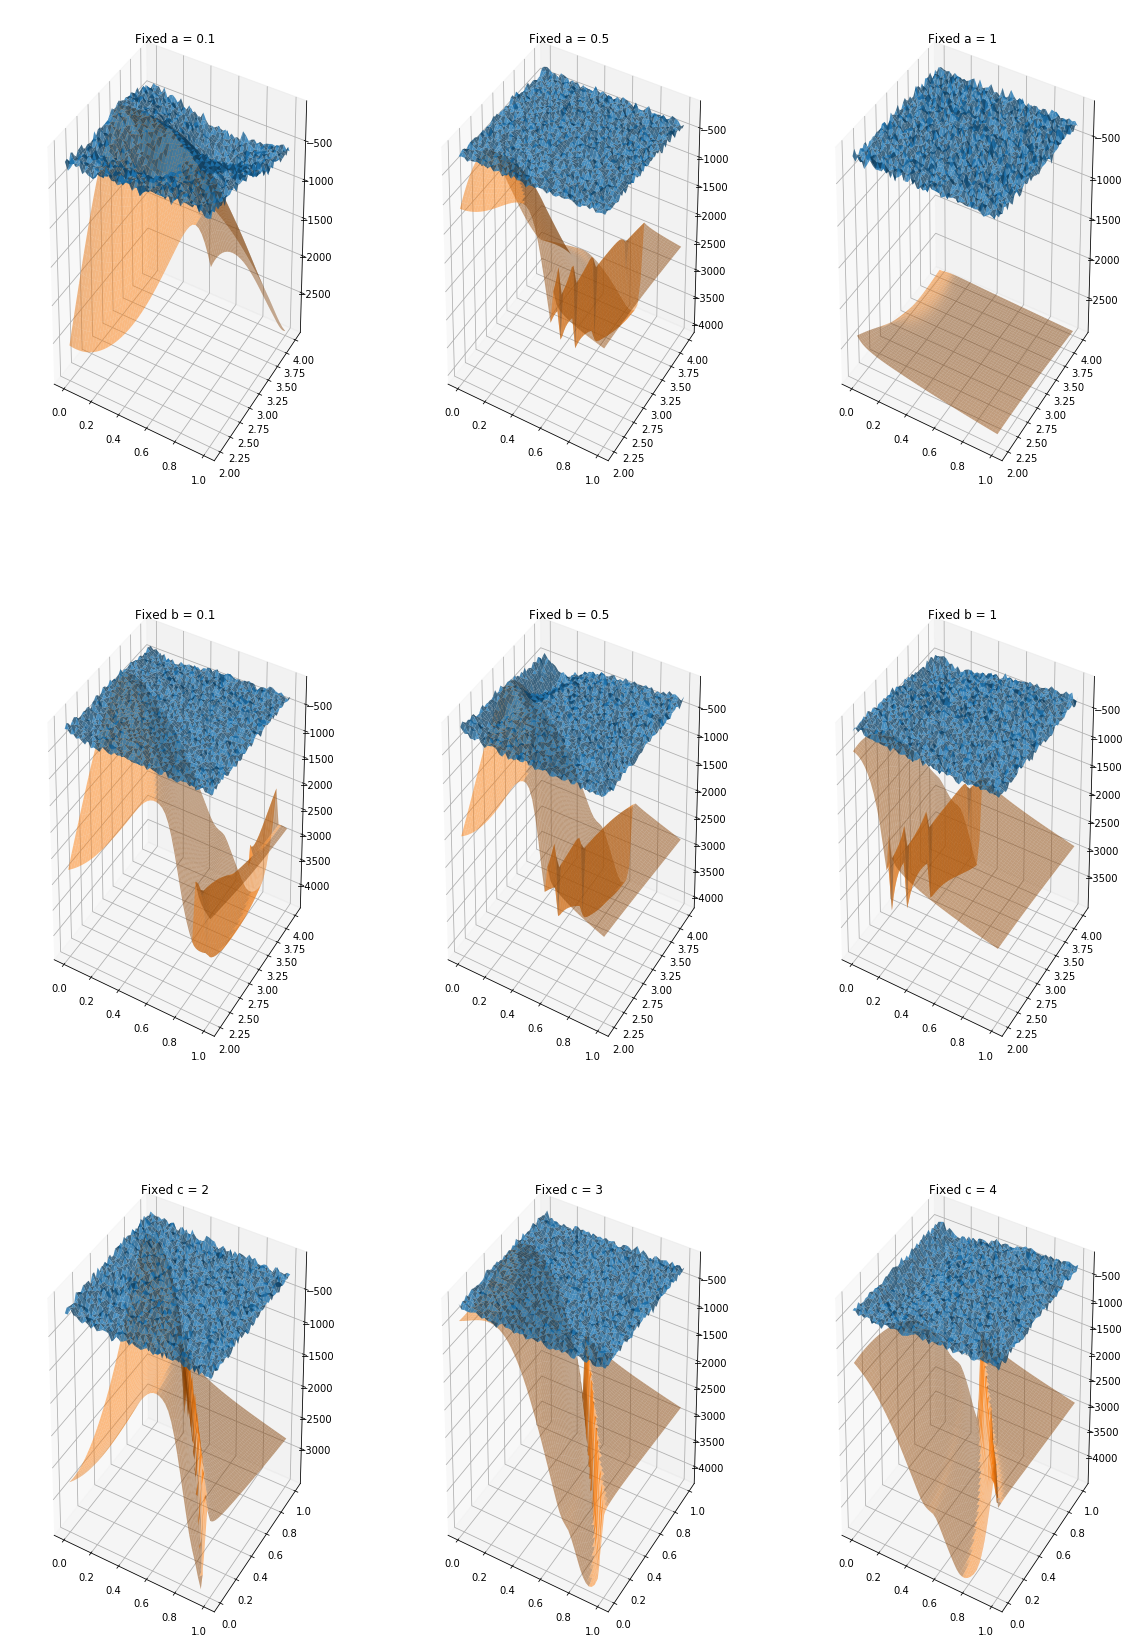

In [58]:
fig, axes = plot_fixed_param_grid(emu, 
                                  parameter_grid, 
                                  index_to_param=index_to_param,
                                  figsize = (20, 30),
                                  countour = False,
                                  additional_likelihoods = [real_log_likelihood]
                              )

## TODO
1. reduce error!
2. automatic kernel selection
3. alternating use of emulator and real model in MCMC? 